# 문장 이진 분류 모델(순환 신경망 모델)

### 0. 사용할 패키지 불러오기 

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Flatten, LSTM

In [2]:
max_features = 20000   # 20,000 번째 단어까지만 사용 
text_max_words = 200   # 문장 길이는 200 단어까지만 사용 

### 1. 데이터셋 생성하기
* IMDB에서 제공하는 영화 리뷰 데이터셋을 이용
* 데이터셋은 훈련셋 25,000개, 시험셋 25,000개의 샘플을 제공
* 라벨은 1과 0으로 좋아요/싫어요로 지정
* 케라스에서 제공하는 imdb의 load_data() 함수을 이용하면 데이터셋을 쉽게 얻을 수 있음. 
* 데이터셋은 이미 정수로 인코딩되어 있으며, 정수값은 단어의 빈도수를 나타냄
* 모든 단어를 고려할 수 없으므로 빈도수가 높은 단어를 위주로 데이터셋을 생성
* 20,000번째로 많이 사용하는 단어까지만 데이터셋으로 만들고 싶다면, num_words 인자에 20000이라고 지정하면 됨.

#### 훈련셋과 시험셋 불러오기

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

* 총 25000개의 샘플
* 각 샘플은 영화 리뷰 한 건을 의미
* 단어의 인덱스로 구성되어 있습니다. 
* num_words=20000’으로 지정했기 때문에 빈도수가 20,000을 넘는 단어는 보이지가 않음
* 훈련셋 25,000개를 다시 훈련셋 20,000개와 검증셋 5,000개로 분리

#### 훈련셋과 검증셋 분리

In [4]:
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

#### 데이터셋 전처리 : 문장 길이 맞추기
* 모델의 입력으로 사용하려면 고정된 길이로 만들어야 함
* 케라스에서 제공되는 전처리 함수인 sequence의 pad_sequences() 함수를 사용
    * 문장의 길이를 maxlen 인자로 맞춰줍니다
    * 예를 들어 200으로 지정했다면 200보다 짧은 문장은 0으로 채워서 200단어로 맞춰주고 200보다 긴 문장은 200단어까지만 잘라냅니다.
    * (num_samples, num_timesteps)으로 2차원의 numpy 배열로 만들어줍니다. 
    * maxlen을 200으로 지정하였다면, num_timesteps도 200이 됩니다.

In [5]:
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

### 2. 모델 구성하기(순환 신경망 모델)
* 문장을 단어들의 시퀀스로 간주하고 순환(LSTM) 레이어의 입력으로 구성한 모델입니다.
* 임베딩 레이어 다음에 LSTM 레이어가 오는 경우에는 임베딩 레이어에 input_length 인자를 따로 설정할 필요는 없습니다.
    * 입력 문장의 길이에 따라 input_length가 자동으로 정해지고, 이것이 LSTM 레이어에는 timesteps으로 입력되기 때문입니다.
* 블록으로 표현한다면 예제에서는 문장의 길이가 200 단어이므로, LSTM 블록 200개가 이어져있다고 생각하면 됩니다.
* LSTM에 입력되는 타임스텝은 Embedding 출력 타임스텝으로 200이고, 특징 크기는 Embedding에서 인코딩된 128입니다.

In [6]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


### 3. 모델 학습과정 설정하기

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 4. 모델 학습시키기

In [8]:
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/2
313/313 [==============================] - 14s 44ms/step - loss: 0.4206 - accuracy: 0.8041 - val_loss: 0.3186 - val_accuracy: 0.8702
Epoch 2/2
313/313 [==============================] - 13s 43ms/step - loss: 0.2138 - accuracy: 0.9196 - val_loss: 0.3212 - val_accuracy: 0.8688


### 5. 학습과정 살펴보기

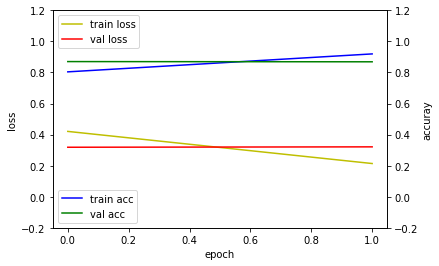

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()  # 여러개의 plot을 한번에 생성 

acc_ax = loss_ax.twinx()       # 서로 다른 y축을 갖지만 공통의 x축을 갖는 플롯  

# loss_ax
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

# acc_ax
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 6. 모델 평가하기

In [10]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

391/391 [==============================] - 3s 8ms/step - loss: 0.3343 - accuracy: 0.8650
## evaluation loss and_metrics ##
[0.3343494236469269, 0.8649600148200989]
